In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score

# import kmeans1d
'''
kmeans1d

A Python library with an implementation of k-means clustering on 1D data, based on the algorithm in (Xiaolin 1991), as presented in section 2.2 of (Gronlund et al., 2017).

Globally optimal k-means clustering is NP-hard for multi-dimensional data. Lloyd's algorithm is a popular approach for finding a locally optimal solution. For 1-dimensional data, there are polynomial time algorithms. The algorithm implemented here is a O(kn + n log n) dynamic programming algorithm for finding the globally optimal k clusters for n 1D data points.

The code is written in C++, and wrapped with Python.
'''

# import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
# shape (381109, 11)
data_1 = pd.read_csv('datasets/d1.csv')
data_1 = data_1.drop(['id'], axis=1)

data_2 = pd.read_csv('datasets/d2.csv')

In [28]:
data_1

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [96]:
from itertools import combinations
columns_name = ['a','b','c']
combX = []
comb_max_depth = 2
for idx, _ in enumerate(columns_name):
    if comb_max_depth and comb_max_depth == idx:
        break
    combX.extend(list(combinations(columns_name, idx + 1)))

sorted(combX, key=len)

[('a',), ('b',), ('c',), ('a', 'b'), ('a', 'c'), ('b', 'c')]

In [63]:
data_1.nunique()

Gender                      2
Age                        66
Driving_License             2
Region_Code                53
Previously_Insured          2
Vehicle_Age                 3
Vehicle_Damage              2
Annual_Premium          48838
Policy_Sales_Channel      155
Vintage                   290
Response                    2
dtype: int64

0    334399
1     46710
Name: Response, dtype: int64

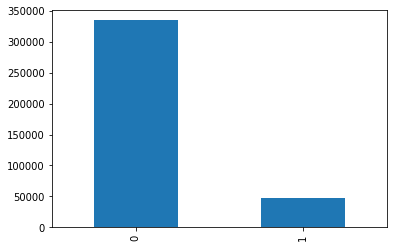

In [389]:
# data_1 = data_1.sample(100)

data_1['Response'].value_counts().plot(kind='bar')
data_1['Response'].value_counts()

In [372]:
data_1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
234381,234382,Male,56,1,28.0,1,1-2 Year,No,61504.0,26.0,190,0
150324,150325,Male,42,1,28.0,0,1-2 Year,Yes,26642.0,124.0,209,0
318133,318134,Male,20,1,47.0,0,< 1 Year,Yes,27825.0,160.0,28,0
32701,32702,Female,44,1,15.0,0,1-2 Year,Yes,47144.0,26.0,248,1
5228,5229,Male,28,1,30.0,1,< 1 Year,No,26401.0,152.0,124,0


In [373]:
top_n = 10 
likely_dis = []

# check if attribute is continuous or discrete dataframe 
for var in data_1.columns:
    # Find the ratio of number of unique values to the total number of unique values. Something like the following
    # if 1.*data_1[var].nunique()/data_1[var].count() > 0.5:

    # Check if the top n unique values account for more than a certain proportion of all values
    if 1.*data_1[var].value_counts(normalize=True).head(top_n).sum() < 0.5:
        likely_dis.append(var)
        
likely_dis

['id', 'Age', 'Annual_Premium', 'Vintage']

In [382]:
# Scaleing is a process of transforming data into a stander values so we can get the best of it
# 
# https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering
scaler =  StandardScaler()
scaled_column_names = [x for x in likely_dis if x.lower() not in ['id']]
data_cluster = data_1[scaled_column_names].copy()
scaled_data = scaler.fit_transform(data_cluster)

data_scaled = data_1.copy()
data_scaled[scaled_column_names] = scaled_data
data_scaled

# [['Vintage','Annual_Premium']]
# scaler.inverse_transform([[0.748795	, 0.574539]])

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
234381,234382,Male,0.894906,1,28.0,1,1-2 Year,No,1.985911,26.0,0.482196,0
150324,150325,Male,0.064091,1,28.0,0,1-2 Year,Yes,-0.242414,124.0,0.729944,0
318133,318134,Male,-1.241475,1,47.0,0,< 1 Year,Yes,-0.166798,160.0,-1.630182,0
32701,32702,Female,0.182779,1,15.0,0,1-2 Year,Yes,1.068042,26.0,1.238480,1
5228,5229,Male,-0.766724,1,30.0,1,< 1 Year,No,-0.257818,152.0,-0.378403,0
...,...,...,...,...,...,...,...,...,...,...,...,...
294505,294506,Male,-0.766724,1,15.0,0,< 1 Year,Yes,0.303450,152.0,-1.330277,0
239009,239010,Female,-0.529348,1,47.0,0,< 1 Year,Yes,-0.659674,152.0,1.290637,0
112311,112312,Female,-0.529348,1,18.0,0,< 1 Year,Yes,-0.213651,26.0,-0.091536,0
111387,111388,Male,-0.648036,1,38.0,0,< 1 Year,Yes,-1.777224,156.0,-1.473710,0


In [381]:
from scipy import stats
data_scaled = data_scaled[(np.abs(stats.zscore(data_scaled.Annual_Premium)) < 3)]
data_scaled

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
234381,234382,Male,0.894906,1,28.0,1,1-2 Year,No,1.985911,26.0,0.482196,0
150324,150325,Male,0.064091,1,28.0,0,1-2 Year,Yes,-0.242414,124.0,0.729944,0
318133,318134,Male,-1.241475,1,47.0,0,< 1 Year,Yes,-0.166798,160.0,-1.630182,0
32701,32702,Female,0.182779,1,15.0,0,1-2 Year,Yes,1.068042,26.0,1.238480,1
5228,5229,Male,-0.766724,1,30.0,1,< 1 Year,No,-0.257818,152.0,-0.378403,0
...,...,...,...,...,...,...,...,...,...,...,...,...
294505,294506,Male,-0.766724,1,15.0,0,< 1 Year,Yes,0.303450,152.0,-1.330277,0
239009,239010,Female,-0.529348,1,47.0,0,< 1 Year,Yes,-0.659674,152.0,1.290637,0
112311,112312,Female,-0.529348,1,18.0,0,< 1 Year,Yes,-0.213651,26.0,-0.091536,0
111387,111388,Male,-0.648036,1,38.0,0,< 1 Year,Yes,-1.777224,156.0,-1.473710,0


In [386]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X = np.array(data_scaled.Annual_Premium.tolist()).reshape(-1,1)

for n_clusters in range(3,9):
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 3 The average silhouette_score is : 0.657733195580059
For n_clusters = 4 The average silhouette_score is : 0.6610266086397653
For n_clusters = 5 The average silhouette_score is : 0.6452126815366188
For n_clusters = 6 The average silhouette_score is : 0.669971895177803
For n_clusters = 7 The average silhouette_score is : 0.6706086301730843
For n_clusters = 8 The average silhouette_score is : 0.630210857801751


[5999.999999999979, 1595.7184828307988, 602.6535070181575, 356.47743944212414, 235.84797664144438, 165.79979997720045, 123.11796475192453, 95.95446027697153, 77.97615875097586]


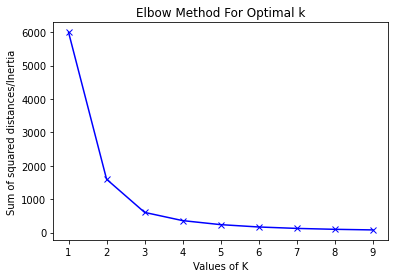

[6000.0000000000255, 2639.1291198006475, 1301.7383089951502, 801.9835068875364, 534.5522887807397, 380.39047045367664, 258.21613045674667, 195.50048974992293, 141.96547414107025]


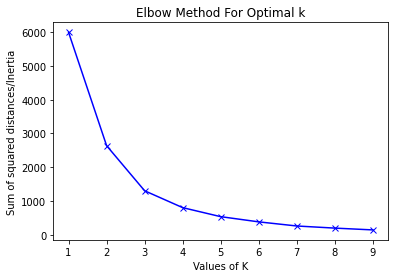

[6000.000000000007, 1491.238436650119, 667.6539033905401, 375.7359924771491, 242.98412890055897, 166.93469305833383, 120.69636417949894, 92.88143156377711, 72.35903712810529]


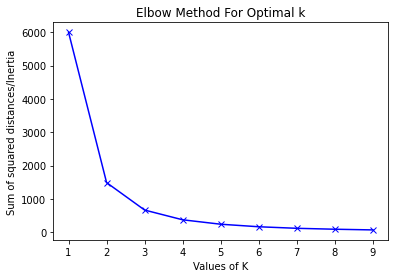

In [317]:
K = range(1,10)
for att in scaled_column_names:
    Sum_of_squared_distances = []
    for num_clusters in K :
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(np.array(data_scaled[att].tolist()).reshape(-1, 1))
        Sum_of_squared_distances.append(kmeans.inertia_)
    print(Sum_of_squared_distances)
    plt.plot(K,Sum_of_squared_distances,"bx-")
    plt.xlabel("Values of K") 
    plt.ylabel("Sum of squared distances/Inertia") 
    plt.title("Elbow Method For Optimal k")
    plt.show()

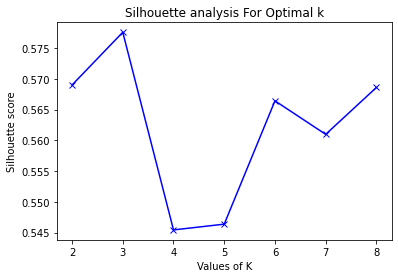

In [321]:
range_n_clusters = range(2,9)
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialize kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(np.array(scaled_data.tolist()).reshape(-1, 1))
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg.append(silhouette_score(scaled_data.reshape(-1, 1), cluster_labels))

plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [319]:
len(scaled_data)

6000

In [241]:
%%time


clustering = DBSCAN(eps=0.5, min_samples=4).fit(
# clustering = KMeans(n_clusters=4).fit(
        np.array(data_1['months_as_customer'].tolist()).reshape(-1, 1)
    )
clustering1 = DBSCAN(eps=0.5, min_samples=4).fit(
# clustering = KMeans(n_clusters=4).fit(
        np.array(data_1['total_claim_amount'].tolist()).reshape(-1, 1)
    )

p = pd.DataFrame(zip(clustering.labels_, clustering1.labels_), columns=['months_as_customer', 'total_claim_amount'])
p.nunique()

CPU times: total: 31.2 ms
Wall time: 18 ms


months_as_customer    98
total_claim_amount    12
dtype: int64

In [57]:
data_after_clsuter = data_scaled.copy()
data_after_clsuter[scaled_column_names] = scaler.inverse_transform(scaled_data)
data_after_clsuter.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
210887,210888,Female,57,1,29.0,0,1-2 Year,Yes,41112.0,26.0,20.0,0
78681,78682,Male,42,1,8.0,0,1-2 Year,Yes,2630.0,156.0,90.0,0
51839,51840,Female,29,1,21.0,1,< 1 Year,No,27799.0,152.0,28.0,0
356263,356264,Male,37,1,46.0,0,1-2 Year,Yes,22458.0,124.0,15.0,0
101819,101820,Female,30,1,28.0,0,< 1 Year,Yes,22578.0,152.0,130.0,0


In [59]:

data_cluster_sort = data_after_clsuter.copy()
data_cluster_sort['cluster'] = clustering.labels_
data_cluster_sort.sort_values(['cluster'], inplace=True)
data_cluster_sort.to_csv('data_cluster_sort.csv')
data_cluster_sort.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,cluster
316653,316654,Female,20,1,27.0,0,< 1 Year,Yes,15055.0,160.0,84.0,0,-1
235360,235361,Male,42,1,28.0,1,1-2 Year,Yes,52975.0,26.0,117.0,0,-1
95102,95103,Male,60,1,8.0,0,1-2 Year,Yes,93902.0,26.0,130.0,1,-1
177621,177622,Female,32,1,7.0,0,1-2 Year,Yes,2630.0,156.0,290.0,1,-1
263182,263183,Male,52,1,3.0,0,1-2 Year,Yes,2630.0,156.0,294.0,1,-1


In [218]:
le = LabelEncoder()
encoder_dict = dict()
data_endocded = data_cluster_sort.copy()

for col in data_endocded:
    if col not in ['Annual_Premium', 'Vintage']:
        le = le.fit(data_endocded[col])
        data_endocded[col] = le.transform(data_endocded[col])
        encoder_dict[col] = le

np.save('encoder_dict.npy', encoder_dict)
# encoder_dict = np.load('encoder_dict.npy', allow_pickle=True).tolist()
data_endocded.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,cluster
316653,82,0,0,0,18,0,1,1,15055.0,12,84.0,0,0
235360,64,1,19,0,19,1,0,1,52975.0,4,117.0,0,0
95102,31,1,33,0,4,0,0,1,93902.0,4,130.0,1,0
177621,49,0,12,0,3,0,0,1,2630.0,10,290.0,1,0
263182,72,1,27,0,2,0,0,1,2630.0,10,294.0,1,0


In [339]:
scaled_data

array([[-1.0298082 ,  0.09662793,  0.59764088],
       [-0.31946204, -0.27981674, -0.16428413],
       [ 1.87615336, -0.24900872, -1.20002594],
       ...,
       [ 0.90749951,  0.36662355, -1.59289352],
       [ 0.97207643, -1.63102717, -1.47384274],
       [ 1.10123028,  0.39561243, -1.24764625]])

For n_clusters = 2 The average silhouette_score is : 0.6840265206545637
For n_clusters = 3 The average silhouette_score is : 0.6571125076315671
For n_clusters = 4 The average silhouette_score is : 0.6462822056664669
For n_clusters = 5 The average silhouette_score is : 0.6264030053639357
For n_clusters = 6 The average silhouette_score is : 0.6239003483066768


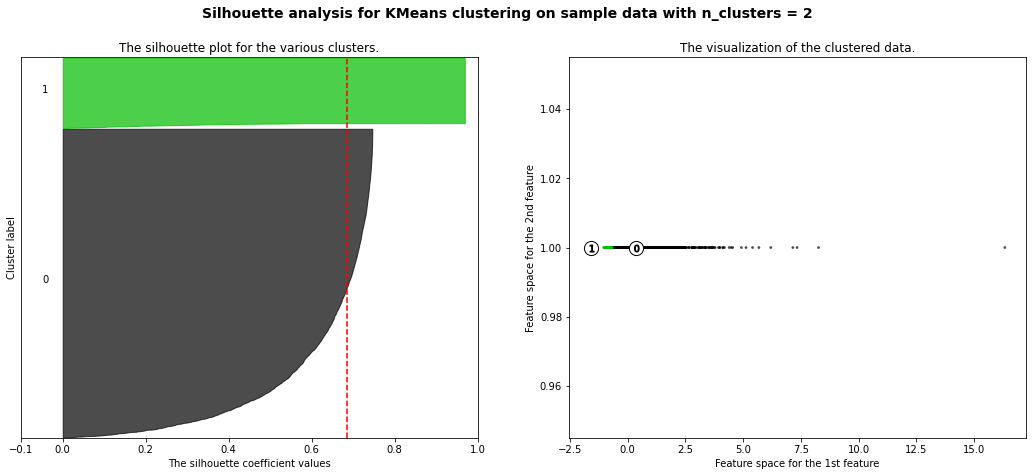

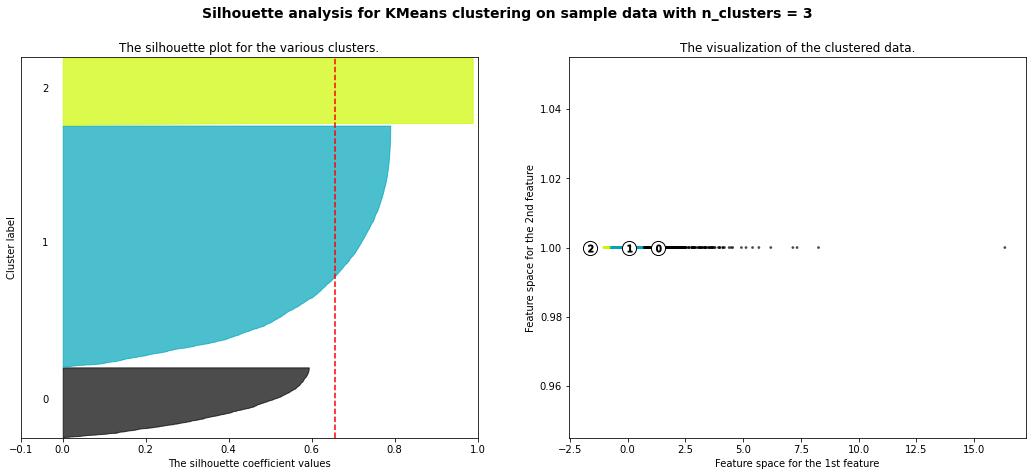

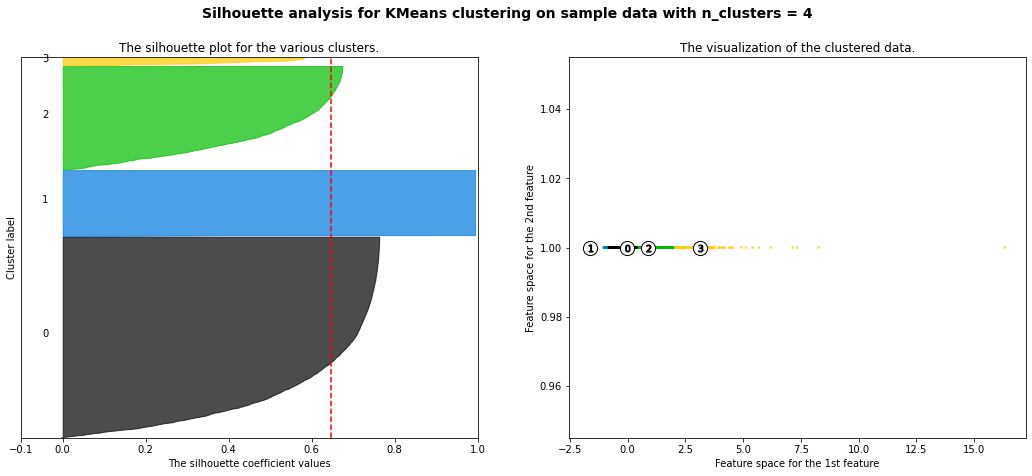

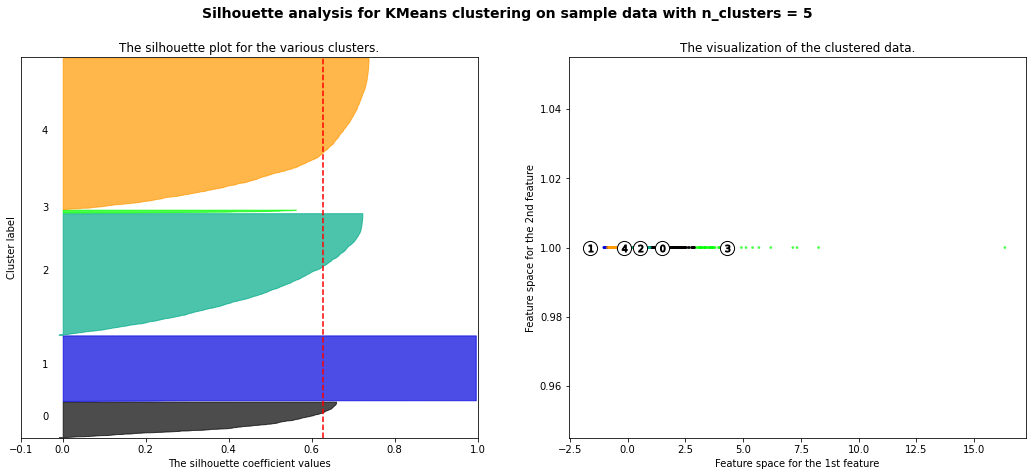

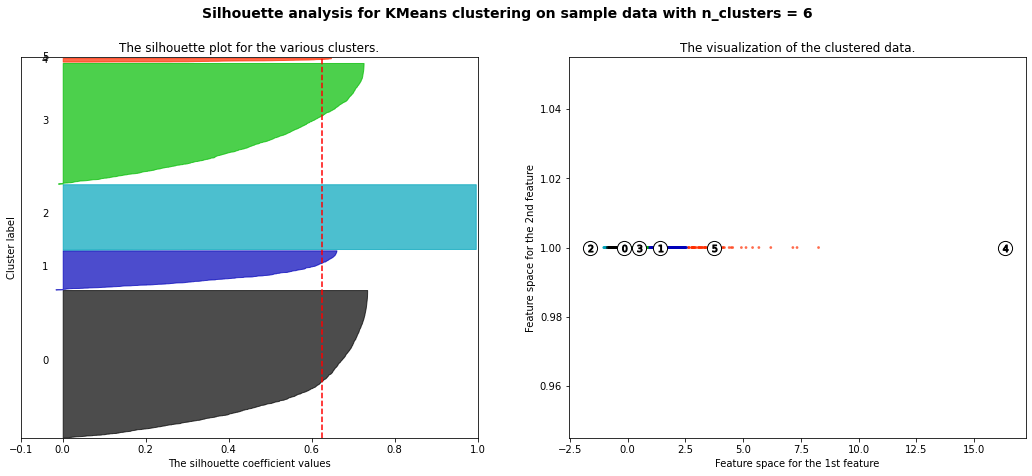